In [1]:
import pandas
import matplotlib.pyplot as plt

### Plot the urban areas in the sample (optional)

<AxesSubplot:>

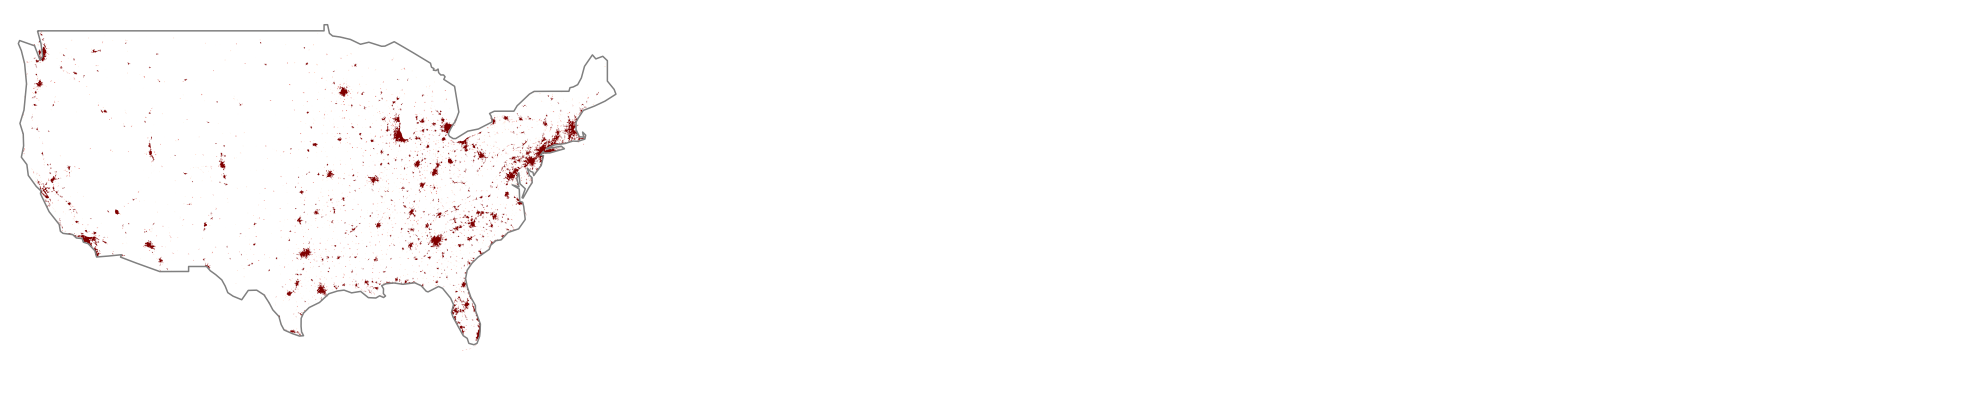

In [2]:
import geopandas

gdf = geopandas.read_file("cb_2018_us_ua10_500k/cb_2018_us_ua10_500k.shp")
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
us = world[world.name=="United States of America"]

fig, ax = plt.subplots(figsize = (35,20))
ax.set_axis_off()

ax.set_xlim([-14000000, 7000000])
ax.set_ylim([2200000, 6500000])

# use this to screen out certain geometries, as needed
gdfbig = gdf
# gdfbig = gdf[gdf.ALAND10 > 50000000]

us.to_crs("EPSG:3395").boundary.plot(
    ax = ax,
    color="grey"
)

gdfbig.to_crs("EPSG:3395").plot(
    ax = ax,
    column='ALAND10', 
    cmap='OrRd', 
    scheme='quantiles'
)

# plt.savefig('big.png', ax=ax)

In [3]:
gdfbig.sort_values("ALAND10", ascending=False)

,UACE10,AFFGEOID10,GEOID10,NAME10,LSAD10,UATYP10,ALAND10,AWATER10,geometry
2627,63217,400C100US63217,63217,"New York--Newark, NY--NJ--CT",75,U,8934084608,534984232,"MULTIPOLYGON (((-72.35716 40.90963, -72.35495 ..."
2443,03817,400C100US03817,03817,"Atlanta, GA",75,U,6851581056,93257528,"MULTIPOLYGON (((-83.71458 34.10093, -83.71320 ..."
789,16264,400C100US16264,16264,"Chicago, IL--IN",75,U,6321883815,110183753,"MULTIPOLYGON (((-87.00951 41.64198, -87.00311 ..."
1633,69076,400C100US69076,69076,"Philadelphia, PA--NJ--DE--MD",75,U,5132240328,127543480,"MULTIPOLYGON (((-74.68335 39.98373, -74.67821 ..."
3302,09271,400C100US09271,09271,"Boston, MA--NH--RI",75,U,4853336622,201355196,"MULTIPOLYGON (((-70.75589 42.08023, -70.75351 ..."
...,...,...,...,...,...,...,...,...,...
537,02825,400C100US02825,02825,"Arbuckle, CA",76,C,1871310,0,"MULTIPOLYGON (((-122.07002 39.01739, -122.0691..."
2477,52352,400C100US52352,52352,"Mabton, WA",76,C,1862540,0,"POLYGON ((-120.00804 46.20747, -119.99975 46.2..."
322,87669,400C100US87669,87669,"Tipton, CA",76,C,1738137,0,"POLYGON ((-119.31977 36.06552, -119.31627 36.0..."
465,55522,400C100US55522,55522,"Mattawa, WA",76,C,1637793,0,"POLYGON ((-119.91535 46.73602, -119.91358 46.7..."


### Save and clean the data for class (optional)

In [4]:
# 2015 emissions, by sector, for each of the 3601 urban areas in the United States.
# Reported hourly.  3.5GB
df = pandas.read_csv("total.2015.hourly.1.31.2022.csv", dtype={"GEOID10": str})

In [5]:
# Each of the variable name is `hXXXX` where X ranges from 1-8760, 
# the number of hours in a year.  Rename to deal with the data.
def rename_vars(vname):
    try:
        hstring, hour = vname.split('h')
        return int(hour)
    except:
        return vname

df = df.rename(rename_vars, axis = 'columns')
df.shape

(39611, 8762)

In [6]:
longdf = df.melt(
    id_vars    = ['GEOID10','Sector'],
    var_name   = 'hour', 
    value_name = 'emissions'
)

In [7]:
# 24 hours, 365 days, 3601 urban areas, 10 sectors (plus 1, a total sum)
print(24 * 365 * 3601 * 11) 

# variables: ID, Sector, hour, emissions value
print(longdf.shape)

346992360
(346992360, 4)


In [8]:
import datetime

def create_date(h):
    start = datetime.datetime(2015, 1, 1)
    return start + datetime.timedelta(hours=h)

# Create a datetime object that can be manipulated from the `hour` variable
longdf["date"] = longdf.hour.apply(create_date)

In [9]:
# Consolidate observations to daily observations
dailydf = longdf.groupby(
    by=["GEOID10", "Sector", longdf['date'].dt.date]
)['emissions'].sum()
dailydf = dailydf.reset_index()

# Save hourly beacause it takes a while to get to this point.
# dailydf.to_csv("hourly.csv", index=False)

In [10]:
# Collapse to total emissions in 2015 and reshape to wide format
totaldf = dailydf.groupby(
    by=["GEOID10", "Sector"]
)["emissions"].sum().reset_index()

# rename columns and round the emissions off to integer
totaldf.columns = ["geoid", "sector", "emissions"]
totaldf["emissions"] = totaldf.emissions.apply(int)

# create a dataframe where each row indicates an urban area
widedf = totaldf.pivot(
    index   = 'geoid', 
    columns = 'sector', 
    values  = 'emissions'
).reset_index()

In [11]:
# Merge in names and geometries
finaldf = widedf.merge(
    gdfbig, 
    left_on  = "geoid", 
    right_on = "GEOID10", 
    how      = "left"
)

name_dict = {
    "geoid": "geoid", 
    "NAME10": "name", 
    "ALAND10": "land_area",
    "Total": "total",
    "airport": "airport",
    "cement": "cement",
    "cmv": "cmv",
    "commercial": "commercial",
    "elec_prod": "elec_prod",
    "industrial": "industrial",
    "nonroad": "nonroad",
    "onroad": "onroad",
    "rail": "rail",
    "residential": "residential",
    "geometry": "geometry"
}

finaldf = finaldf[list(name_dict.keys())].rename(columns=name_dict)

# create a geojson
geodata = geopandas.GeoDataFrame(finaldf, geometry='geometry')
geodata.to_file("wide_2015.geojson", driver='GeoJSON')

# create a CSV without geometry
finaldf = finaldf.drop(columns=["geometry"])
finaldf.to_csv("wide_2015.csv", index=False)

### Finding anomalies

In [12]:
xdf = pandas.read_csv("wide_2015.csv", dtype={"geoid": str})
xdf.describe()

,land_area,total,airport,cement,cmv,commercial,elec_prod,industrial,nonroad,onroad,rail,residential
count,3.601000e+03,3.601000e+03,3601.000000,3601.000000,3601.000000,3.601000e+03,3.601000e+03,3.601000e+03,3.601000e+03,3.601000e+03,3601.000000,3.601000e+03
mean,7.784623e+07,2.032324e+05,3425.416551,621.012774,1411.847265,1.557914e+04,3.715739e+04,3.872143e+04,8.958365e+03,7.817487e+04,945.931963,1.823435e+04
std,3.537231e+08,1.351423e+06,22677.631158,11203.154311,21492.387934,1.385491e+05,2.983331e+05,3.586579e+05,6.604053e+04,4.680676e+05,7656.417241,1.845132e+05
min,7.413460e+05,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,6.767091e+06,4.863000e+03,0.000000,0.000000,0.000000,2.260000e+02,0.000000e+00,4.100000e+01,1.770000e+02,3.104000e+03,0.000000,2.960000e+02
50%,1.260917e+07,1.231100e+04,0.000000,0.000000,0.000000,7.480000e+02,0.000000e+00,4.260000e+02,4.600000e+02,7.288000e+03,45.000000,9.460000e+02
75%,3.070313e+07,3.954100e+04,20.000000,0.000000,0.000000,2.967000e+03,0.000000e+00,3.584000e+03,1.606000e+03,1.995000e+04,377.000000,3.182000e+03
max,8.934085e+09,3.906160e+07,697155.000000,398873.000000,795429.000000,5.897696e+06,9.053951e+06,1.209523e+07,2.069385e+06,1.165779e+07,384202.000000,8.500357e+06


In [13]:
# how many have *zero* emissions measured
xdf[xdf.total == 0].shape

(28, 14)

In [14]:
# only ~20 of the 3601 urban areas have cement production within the boundary,

# CMV is commercial marine vessels - aka shipping. Most urban areas will have 
# a very small intersection with bodies of water, and so the CMV should be 
# pretty low.
for c in xdf.columns:
    rows, columns = xdf[xdf[c] == 0].shape
    print(f"Number urban areas with zero emissions for {c}: {rows} out of 3601")

Number urban areas with zero emissions for geoid: 0 out of 3601
Number urban areas with zero emissions for name: 0 out of 3601
Number urban areas with zero emissions for land_area: 0 out of 3601
Number urban areas with zero emissions for total: 28 out of 3601
Number urban areas with zero emissions for airport: 2190 out of 3601
Number urban areas with zero emissions for cement: 3580 out of 3601
Number urban areas with zero emissions for cmv: 3279 out of 3601
Number urban areas with zero emissions for commercial: 41 out of 3601
Number urban areas with zero emissions for elec_prod: 2872 out of 3601
Number urban areas with zero emissions for industrial: 433 out of 3601
Number urban areas with zero emissions for nonroad: 28 out of 3601
Number urban areas with zero emissions for onroad: 30 out of 3601
Number urban areas with zero emissions for rail: 993 out of 3601
Number urban areas with zero emissions for residential: 30 out of 3601


In [15]:
for v in ["nonroad", "onroad", "residential", "commercial"]:
    xdf = xdf[xdf[v] > 0]

for c in xdf.columns:
    rows, columns = xdf[xdf[c] == 0].shape
    print(f"Number urban areas with zero emissions for {c}: {rows} out of 3601")

xdf.shape

Number urban areas with zero emissions for geoid: 0 out of 3601
Number urban areas with zero emissions for name: 0 out of 3601
Number urban areas with zero emissions for land_area: 0 out of 3601
Number urban areas with zero emissions for total: 0 out of 3601
Number urban areas with zero emissions for airport: 2147 out of 3601
Number urban areas with zero emissions for cement: 3536 out of 3601
Number urban areas with zero emissions for cmv: 3235 out of 3601
Number urban areas with zero emissions for commercial: 0 out of 3601
Number urban areas with zero emissions for elec_prod: 2829 out of 3601
Number urban areas with zero emissions for industrial: 396 out of 3601
Number urban areas with zero emissions for nonroad: 0 out of 3601
Number urban areas with zero emissions for onroad: 0 out of 3601
Number urban areas with zero emissions for rail: 953 out of 3601
Number urban areas with zero emissions for residential: 0 out of 3601


(3557, 14)

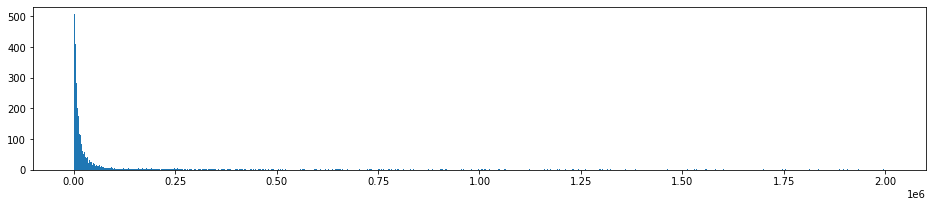

In [16]:
plt.figure(figsize=(16, 3))
fig = plt.hist(xdf.total, range=[0, 2000000], bins=1000)

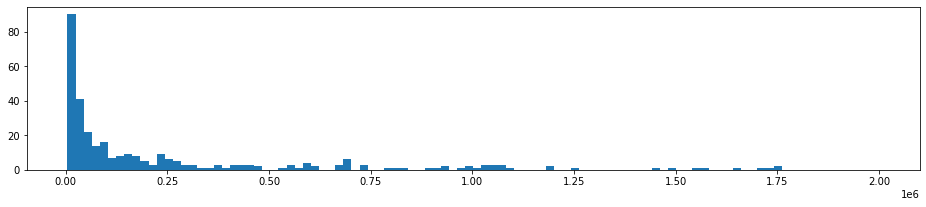

In [17]:
plt.figure(figsize=(16, 3))
fig = plt.hist(xdf[xdf.elec_prod > 0].elec_prod, bins=100, range=[4000,2000000])

In [20]:
# print(xdf.sort_values("total", ascending=False)[100:130])


def create_text(geoid):
    
    o = xdf[xdf.geoid == str(geoid)]
    
    x = pandas.melt(o, id_vars=["geoid", "name", "land_area"])
    
    mxv = x[x.variable != "total"].value.max()
    [var] = list(x[x.value == mxv].variable)
    perc = int((mxv / list(o.total)[0])*100)
    
    s = f"The total emissions in {list(o.name)[0]} over 2015 is {list(o.total)[0]} tCO2e. The single sector that contributed most emissions was {var.upper()} at {perc} percent of total emissions."
    return s

for g in [87544, 78661, 36946, 74746]:
    print("\n")
    print(create_text(g))




The total emissions in Thurmont, MD over 2015 is 10830 tCO2e. The single sector that contributed most emissions was ONROAD at 71 percent of total emissions.


The total emissions in San Diego, CA over 2015 is 5113263 tCO2e. The single sector that contributed most emissions was ONROAD at 55 percent of total emissions.


The total emissions in Harriman--Kingston--Rockwood, TN over 2015 is 1244465 tCO2e. The single sector that contributed most emissions was ELEC_PROD at 95 percent of total emissions.


The total emissions in Richmond, VA over 2015 is 4642191 tCO2e. The single sector that contributed most emissions was ELEC_PROD at 58 percent of total emissions.
